# ***Air Quality Project***

# ***About Dataset***
[Kaggle Data set link](https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment)
This dataset focuses on air quality assessment across various regions. It contains **5,000 samples** and captures critical environmental and demographic factors that influence pollution levels.
## Key Features
- **Temperature (°C):** Average temperature of the region.
- **Humidity (%):** Relative humidity recorded in the region.
- **PM2.5 Concentration (µg/m³):** Fine particulate matter levels.
- **PM10 Concentration (µg/m³):** Coarse particulate matter levels.
- **NO2 Concentration (ppb):** Nitrogen dioxide levels.
- **SO2 Concentration (ppb):** Sulfur dioxide levels.
- **CO Concentration (ppm):** Carbon monoxide levels.
- **Proximity to Industrial Areas (km):** Distance to the nearest industrial zone.
- **Population Density (people/km²):** Number of people per square kilometer in the region.
## Target Variable: Air Quality Levels
- **Good:** Clean air with low pollution levels.
- **Moderate:** Acceptable air quality but with some pollutants present.
- **Poor:** Noticeable pollution that may cause health issues for sensitive groups.
- **Hazardous:** Highly polluted air posing serious health risks to the population.


# ***Import Tools and Libraries***


In [ ]:
! pip install mltable azure-ai-ml azure-identity opencensus-ext-azure joblib optuna mlflow numpy pandas matplotlib seaborn plotly scikit-learn requests streamlit


In [2]:
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Model, Environment, CodeConfiguration, ManagedOnlineEndpoint, ManagedOnlineDeployment 
from opencensus.ext.azure.log_exporter import AzureLogHandler
import logging
import joblib
import optuna
import mlflow
import mlflow.sklearn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc,roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, log_loss
from warnings import filterwarnings
import time
import random
import string
import requests
from itertools import cycle
import json
import streamlit
filterwarnings('ignore')


# ***Set Environment***
This Python script dynamically generates a conda.yaml file to define a custom machine learning environment with specific dependencies and integrates it with Azure Machine Learning. It then creates or updates the environment in Azure ML using the MLClient and lists all existing environments.

In [3]:
# Create an instance of MLClient
ml_client = MLClient.from_config(credential=DefaultAzureCredential())


Found the config file in: /config.json


In [4]:
# Dynamically create a conda.yaml file
conda_content = """
name: custom-mlflow-env
channels:
  - defaults
  - conda-forge
dependencies:
  - python=3.8
  - pip
  - numpy
  - pandas
  - scikit-learn
  - matplotlib
  - seaborn
  - plotly
  - mlflow
  - optuna
  - joblib
  - pip:
      - azureml-mlflow
      - azureml-inference-server-http
      - azureml-defaults
      - mltable
      - azure-ai-ml
      - mlflow.pyfunc
"""

# Save the contents to a file
conda_file_path = "conda.yaml"
with open(conda_file_path, "w") as f:
    f.write(conda_content)

print(f"conda.yaml file created : {conda_file_path}")


conda.yaml file created : conda.yaml


In [5]:
# Set and save the environment
custom_env = Environment(
    name="custom-mlflow-env",
    description="Environnement personnalisé avec MLflow et scikit-learn",
    conda_file=conda_file_path,  # Generated conda.yaml file
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    version="2.0" # Explicitly set a version
)

# Create or update the environment
custom_env = ml_client.environments.create_or_update(custom_env)
print(f"Personalized environment '{custom_env.name}' with version '{custom_env.version}' successfully created.")



Personalized environment 'custom-mlflow-env' with version '2.0' successfully created.


In [6]:
environments = ml_client.environments.list()
for env in environments:
    print(env.name)


custom-conda-env
DefaultNcdEnv-mlflow-ubuntu20-04-py38-cpu-inference
custom-mlflow-env
AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu


# ***Loading Data***

In [7]:
data_asset = ml_client.data.get("Air_Quality_Dataset", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good


# ***Exploratory Data Analysis***

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [11]:
df.isnull().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

In [12]:
df.isna().any()

Temperature                      False
Humidity                         False
PM2.5                            False
PM10                             False
NO2                              False
SO2                              False
CO                               False
Proximity_to_Industrial_Areas    False
Population_Density               False
Air Quality                      False
dtype: bool

In [13]:
df.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [14]:
# Analyze the distribution of the Air Quality variable
air_quality_counts = df['Air Quality'].value_counts()
print(air_quality_counts)

Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: Air Quality, dtype: int64


### General interpretation 
1. **Data Structure**: The dataset contains 5,000 rows and 10 columns, including 8 continuous numerical columns, 1 discrete numerical column, and 1 categorical column ('Air Quality'). The memory size is 390.8 KB.

2. **Missing Data**: There are no missing or null values in the dataset, which means it is complete and ready for analysis.

3. **Descriptive Statistics**:
   - The means, medians, and ranges of the variables reveal significant diversity in the values. For example:
     - Temperature: Average of 30°C, range from 13.4°C to 58.6°C.
     - PM2.5: Average of 20.1 µg/m³, but an extreme maximum value of 295 µg/m³.
     - Industrial proximity: Average of 8.4 km, but some areas are only 2.5 km away from industrial sites.
   - Unexpected minimum values (e.g., negative SO2) suggest potential anomalies to investigate.

4. **Air Quality Distribution**:
   - **Good quality**: 2,000 samples (40%).
   - **Moderate**: 1,500 samples (30%).
   - **Poor**: 1,000 samples (20%).
   - **Hazardous**: 500 samples (10%).
   - The majority of samples have acceptable air quality (good or moderate), but 30% indicate concerning levels of pollution.

The dataset is well-structured, complete, and free of missing data. Initial observations show interesting variations in environmental factors and potential anomalies worth exploring. The air quality distribution reveals that nearly a third of the samples require particular attention due to pollution.


# ***Visualization:***

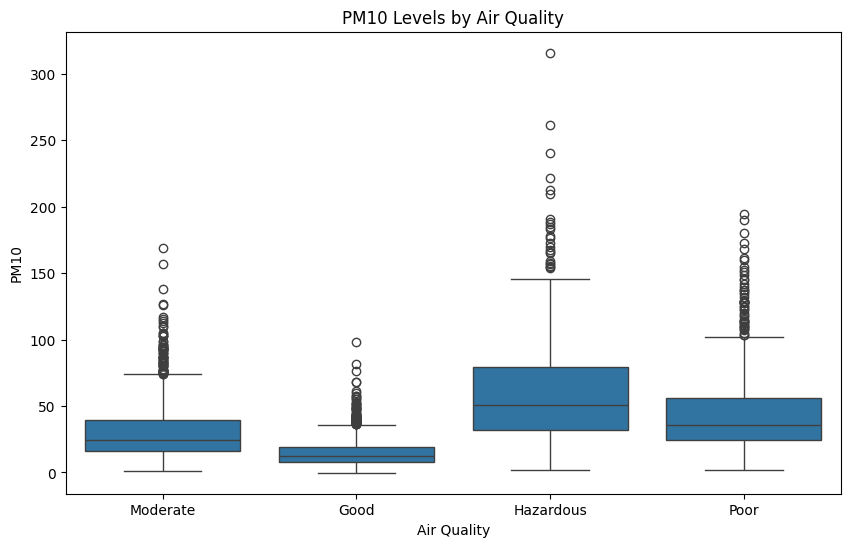

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Air Quality', y='PM10', data=df)
plt.title('PM10 Levels by Air Quality')
plt.show()

### Interpretation of PM10 Levels by Air Quality:

1. **Good Air Quality (Good):**
   - **PM10** levels are generally low, with values mostly below 50 µg/m³.
   - Few outliers are present, confirming that this category corresponds to a low level of pollution.

2. **Moderate Air Quality (Moderate):**
   - **PM10** levels are slightly higher than in the "Good" category, with a median close to 25–50 µg/m³.
   - Greater dispersion of values, with several outliers reaching up to 100 µg/m³.

3. **Poor Air Quality (Poor):**
   - **PM10** levels are significantly higher, with a median above 50 µg/m³.
   - Values are dispersed, and some outliers reach very high levels.

4. **Hazardous Air Quality (Hazardous):**
   - **PM10** levels are the highest, with a median well above 100 µg/m³.
   - Dispersion is significant, with numerous outliers exceeding 150 µg/m³, sometimes reaching extreme values.

**PM10** levels clearly increase as air quality deteriorates, confirming that this variable is a key factor in pollution. The "Hazardous" category shows particularly concerning PM10 levels, indicating a high health risk.


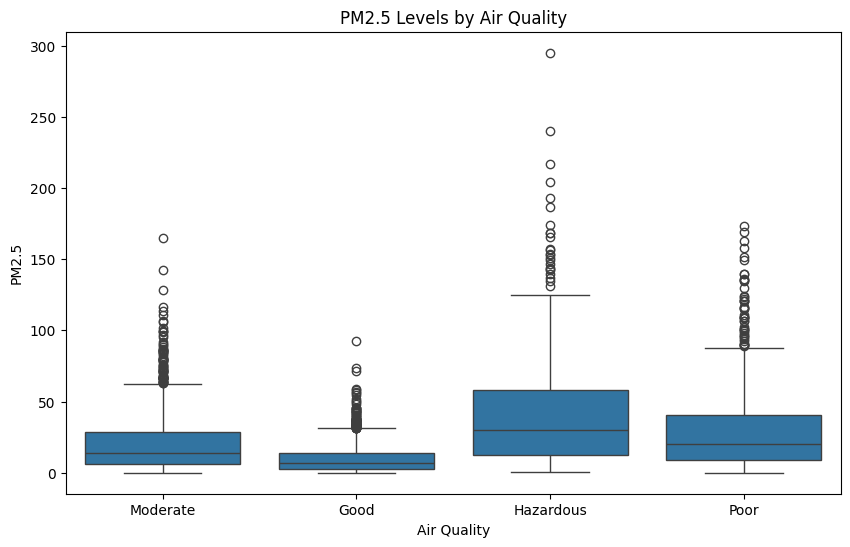

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Air Quality', y='PM2.5', data=df)
plt.title('PM2.5 Levels by Air Quality')
plt.show()

### Interpretation of PM2.5 Levels by Air Quality:

1. **Good Air Quality (Good):**
   - **PM2.5** levels are generally low, with a median below 20 µg/m³.
   - Minimal dispersion of values and a few outliers exceeding 50 µg/m³.

2. **Moderate Air Quality (Moderate):**
   - **PM2.5** levels increase slightly compared to the "Good" category, with a median around 25 µg/m³.
   - Greater dispersion of values, with several outliers reaching or exceeding 100 µg/m³.

3. **Poor Air Quality (Poor):**
   - **PM2.5** levels are significantly higher, with a median around 50 µg/m³.
   - Marked dispersion, with outliers reaching up to 150 µg/m³.

4. **Hazardous Air Quality (Hazardous):**
   - **PM2.5** levels are the highest, with a median far exceeding 75 µg/m³.
   - Significant dispersion, with several outliers reaching extreme values above 200 µg/m³.

**PM2.5** levels increase considerably as air quality deteriorates, highlighting their role as a key indicator of pollution. The "Hazardous" category shows high concentrations of PM2.5, representing a serious risk to public health. Compared to PM10, **PM2.5** appears to be more strongly correlated with the decline in air quality.


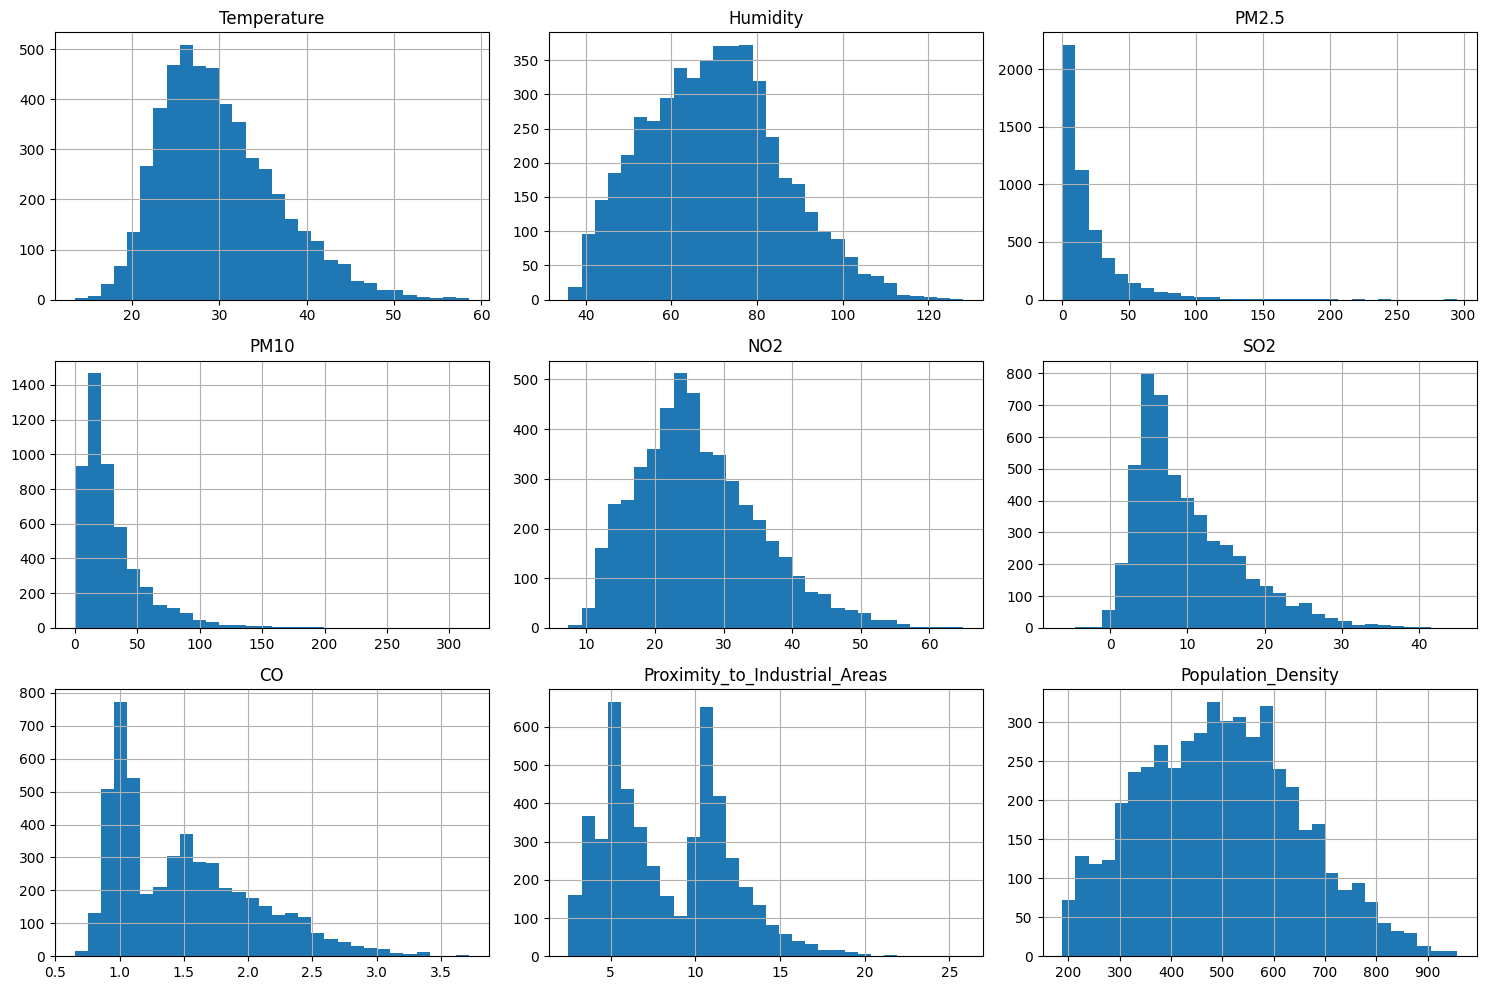

In [17]:
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

### Interpretation of the Overall Distribution Visualization:

1. **Temperature**:
   - Bell-shaped distribution with an average around 30°C.
   - Most values fall between 20°C and 40°C.

2. **Humidity**:
   - Symmetrical distribution centered around 70%.
   - Few extreme values, with a typical range between 50% and 90%.

3. **PM2.5 and PM10**:
   - Highly skewed distribution with the majority of values low (below 50).
   - A few very high outliers.

4. **Nitrogen Dioxide (NO2)**:
   - Bell-shaped distribution centered around 25–30 ppb.
   - Moderate dispersion, with some significant maximum values.

5. **Sulfur Dioxide (SO2)**:
   - Skewed distribution, with most values low (around 5–10 ppb).
   - Some high outliers that warrant further investigation.

6. **Carbon Monoxide (CO)**:
   - Skewed distribution centered around 1–1.5 ppm.
   - High levels are rare but present.

7. **Proximity to Industrial Areas**:
   - Two distinct peaks indicating groups of regions at different distances from industrial areas (around 5 km and 10 km).
   - This suggests that the samples might be divided into urban areas close to and far from industries.

8. **Population Density**:
   - Bell-shaped distribution centered around 500 inhabitants/km².
   - Indicates a predominantly urban population, with few highly dense or sparsely populated areas.

- Temperature and humidity distributions are relatively normal and well-distributed.
- Pollutants such as PM2.5, PM10, SO2, NO2, and CO show marked asymmetries, indicating highly polluted areas that deserve special attention.
- Proximity to industrial areas suggests possible geographical clustering in the data, which could be explored further.


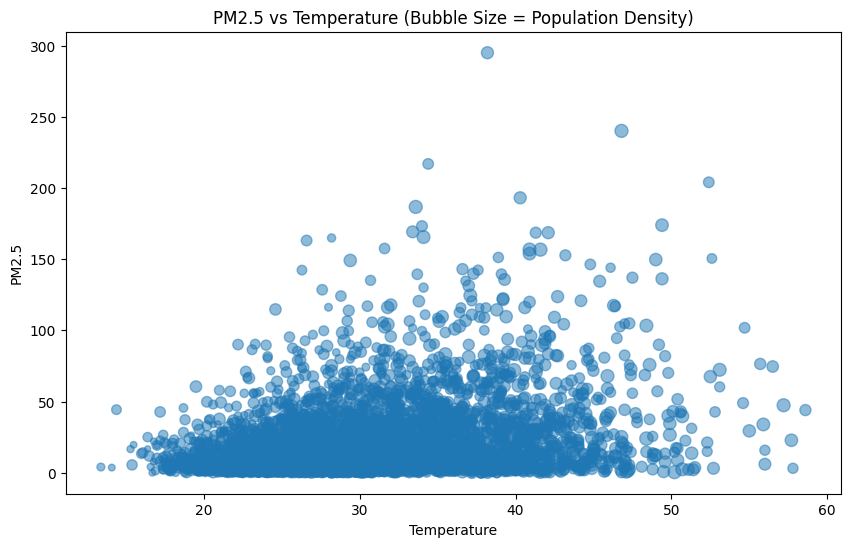

In [18]:
# 10. Bubble Chart for PM2.5
plt.figure(figsize=(10, 6))
plt.scatter(df['Temperature'], df['PM2.5'], s=df['Population_Density']/10, alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('PM2.5')
plt.title('PM2.5 vs Temperature (Bubble Size = Population Density)')
plt.show()

### Interpretation of PM2.5 vs Temperature:

1. **Relationship Between Temperature and PM2.5**:
   - Lower concentrations of **PM2.5** are observed at lower temperatures (below 30°C).
   - **PM2.5** levels slightly increase with temperature, though there is no clearly linear correlation.
   - A few extreme outliers show very high **PM2.5** levels (>150 µg/m³), irrespective of temperature.

2. **Impact of Population Density (Bubble Size)**:
   - Areas with **high population density** (large bubbles) show slightly higher concentrations of **PM2.5**, suggesting that densely populated regions may be more exposed to pollution.
   - Points representing low population density (small bubbles) tend to have lower **PM2.5** levels, though exceptions exist.

3. **General Observations**:
   - The majority of points are concentrated within low to moderate **PM2.5** levels (<50 µg/m³).
   - Higher temperatures (>40°C) do not consistently show increased **PM2.5** levels, suggesting that other factors (such as industrial proximity or traffic) may contribute more significantly to pollution.

This visualization highlights a slight influence of temperature and population density on **PM2.5** levels. Densely populated areas appear more vulnerable to higher pollution levels, but other environmental or anthropogenic factors should be explored to better understand the variations in **PM2.5**.


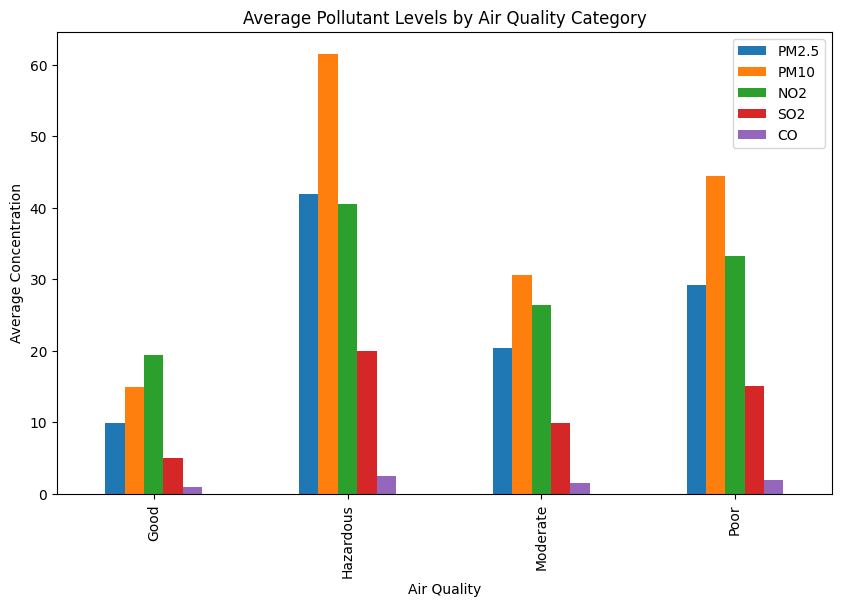

In [19]:
# Average Pollutant Levels by Air Quality Category
avg_pollutants = df.groupby('Air Quality').mean()[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']]
avg_pollutants.plot(kind='bar', figsize=(10, 6))
plt.title('Average Pollutant Levels by Air Quality Category')
plt.ylabel('Average Concentration')
plt.show()

### Interpretation of Average Pollutant Levels by Air Quality Category:

1. **"Good" Category (Good Air Quality)**:
   - Average concentrations of all pollutants are low.
   - Fine particles (**PM2.5**) and coarse particles (**PM10**) have moderate levels (around 10–15 µg/m³).
   - Other pollutants, such as **NO2**, **SO2**, and **CO**, have very low concentrations.

2. **"Moderate" Category (Moderate Air Quality)**:
   - An increase is observed across all pollutant categories compared to "Good."
   - **PM10** and **PM2.5** show significant increases, reflecting their major role in air quality degradation.
   - **NO2** and **SO2** also increase but remain less dominant.

3. **"Poor" Category (Poor Air Quality)**:
   - Concentrations of fine (**PM2.5**) and coarse particles (**PM10**) continue to rise, with **PM10** levels reaching nearly 40 µg/m³.
   - **NO2** shows a similar increase, reaching around 30 µg/m³.
   - **SO2** and **CO** levels also increase, though less markedly.

4. **"Hazardous" Category (Hazardous Air Quality)**:
   - **PM10** and **PM2.5** reach their highest levels, with **PM10** dominating (around 60 µg/m³).
   - **NO2** and **SO2** concentrations are also very high, contributing significantly to pollution.
   - **CO** remains relatively stable compared to other pollutants.

- **PM10** and **PM2.5** are the primary contributors to declining air quality, particularly in the "Poor" and "Hazardous" categories.
- **NO2** and **SO2** play a secondary but critical role in higher pollution levels.
- The "Hazardous" category poses a serious health risk due to extremely high concentrations of particulate matter and harmful gases.

These findings confirm the need for focused efforts to reduce particulate matter and gaseous pollutants to improve air quality and mitigate health risks.


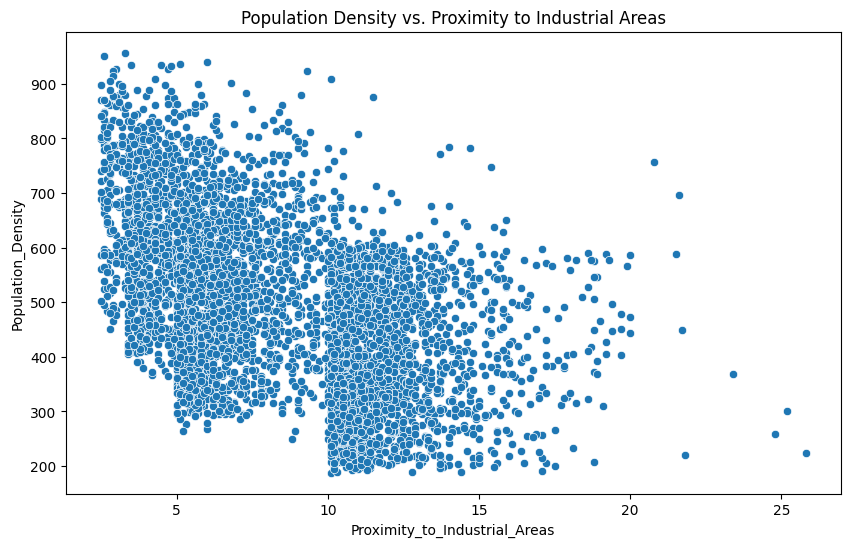

In [20]:
# Population Density vs. Proximity to Industrial Areas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Proximity_to_Industrial_Areas', y='Population_Density', data=df)
plt.title('Population Density vs. Proximity to Industrial Areas')
plt.show()

### Interpretation of Population Density vs Proximity to Industrial Areas:

1. **Population Density Distribution**:
   - Population density primarily ranges between 200 and 900 inhabitants/km².
   - There is a slight trend indicating that areas with higher population density (600–900 inhabitants/km²) are closer to industrial zones (5–10 km).

2. **Proximity to Industrial Areas**:
   - Most data points are concentrated around two distance groups: approximately **5 km** and **10 km** from industrial zones. This suggests a clear segmentation of samples into two main clusters.

3. **Overall Trend**:
   - Areas farther from industrial zones (>15 km) tend to have lower population density, although a few isolated points show high densities.
   - This could indicate that industrial zones influence urbanization, or that sparsely populated areas are generally located farther from industrial activities.

This visualization highlights a moderate correlation between **proximity to industrial areas** and **population density**, with densely populated areas being closer to industrial activity. These findings suggest a potential link between industrialization and urbanization, warranting further exploration to better understand the interactions between economic development and population density.


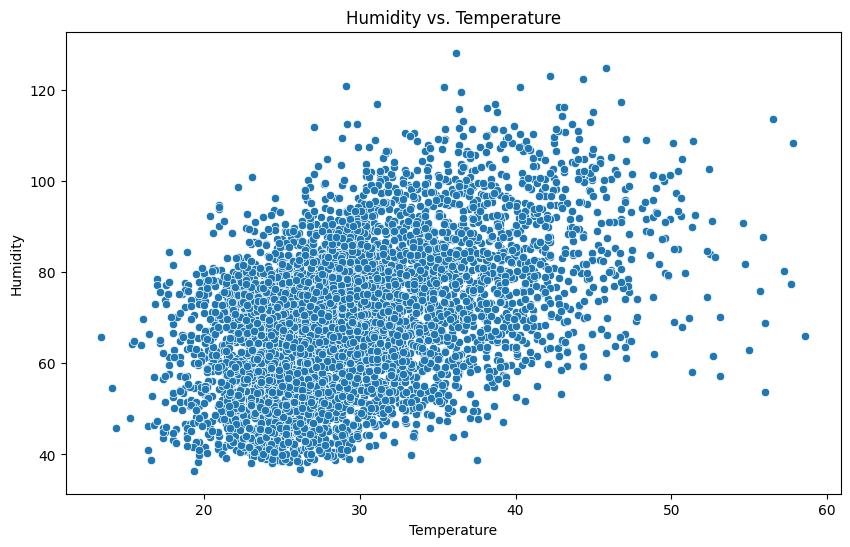

In [21]:
# Humidity vs. Temperature Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Humidity', data=df)
plt.title('Humidity vs. Temperature')
plt.show()

### Interpretation of Humidity vs Temperature:

1. **Relationship Between Humidity and Temperature**:
   - A slight negative correlation is observed: as **temperature** increases, **humidity** values tend to decrease slightly.
   - However, the points are highly scattered, indicating instances where high temperatures are associated with high humidity and vice versa.

2. **Main Ranges**:
   - **Temperature** is concentrated between 20°C and 40°C.
   - **Humidity** primarily ranges between 50% and 90%, with a few extreme values exceeding 100% (potential anomalies or measurement errors).

3. **General Observations**:
   - The central density of points suggests that most analyzed regions have moderate temperatures and humidity levels.
   - Extreme values (very low or very high) are rare and might require specific analysis.

While a general trend is evident (higher temperatures associated with lower humidity), the relationship between these two variables is complex and non-linear. The results might be influenced by other climatic or regional factors, warranting further analysis to identify clearer correlations.


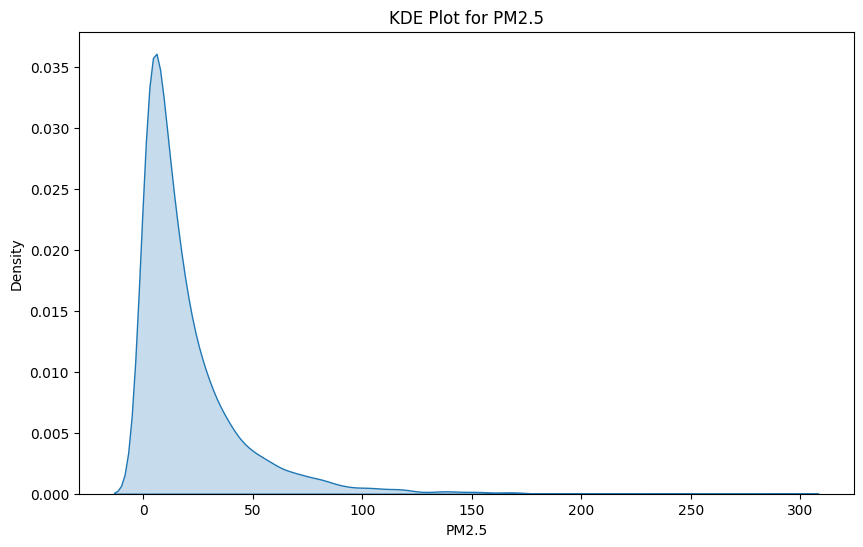

In [22]:
# KDE Plot for PM2.5
plt.figure(figsize=(10, 6))
sns.kdeplot(df['PM2.5'], fill=True)
plt.title('KDE Plot for PM2.5')
plt.show()

### Interpretation of KDE Plot for PM2.5:

1. **Shape of the Distribution**:
   - The distribution of **PM2.5** levels is **highly skewed**, with a sharp peak at lower levels (around **10 µg/m³**).
   - The density decreases rapidly at higher levels, indicating that most **PM2.5** values are concentrated in the lower range.

2. **Concentration of Values**:
   - A large proportion of the analyzed regions exhibit **PM2.5** levels below **50 µg/m³**.
   - A few extreme values exceed **150 µg/m³**, though these cases are rare, as shown by the long tail of the distribution.

3. **General Observations**:
   - The dominant concentration at lower **PM2.5** levels suggests that air quality is generally good to moderate in most regions.
   - Extreme values may indicate industrial areas, high traffic zones, or specific pollution events.

This visualization confirms that most regions have low **PM2.5** levels, but outliers (high levels) require particular attention to identify potential pollution sources. The long tail of the distribution highlights specific areas where air quality is significantly degraded.


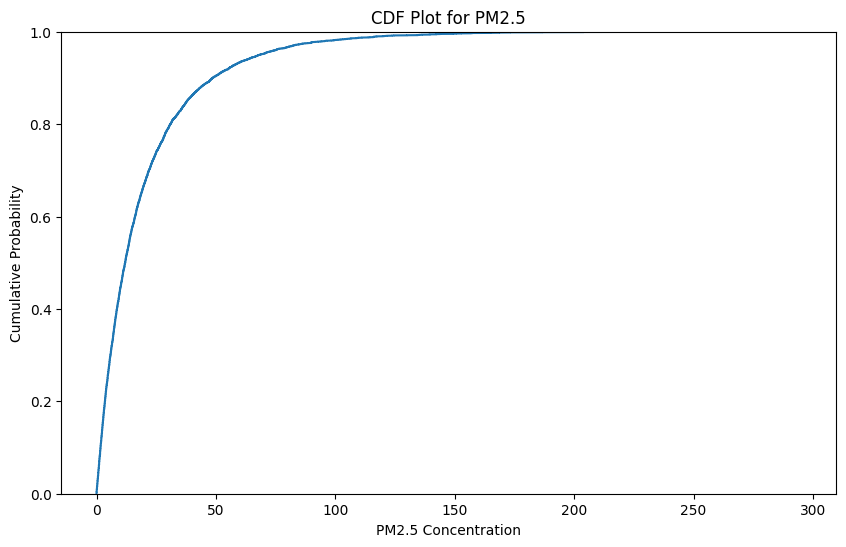

In [23]:
# CDF Plot for PM2.5
plt.figure(figsize=(10, 6))
sns.ecdfplot(df['PM2.5'])
plt.title('CDF Plot for PM2.5')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Cumulative Probability')
plt.show()

### Interpretation of CDF Plot for PM2.5:

1. **Overall Trend**:
   - The cumulative distribution function (CDF) for **PM2.5** shows a steep rise, indicating that most **PM2.5** values are concentrated in a low to moderate range.

2. **Cumulative Probabilities**:
   - Approximately **80% of regions** have **PM2.5** levels below **50 µg/m³**, corresponding to good or moderate air quality.
   - Nearly **100% of regions** have levels below **150 µg/m³**, though a few extreme values exist, with a long tail extending up to **300 µg/m³**.

3. **Observations on Critical Thresholds**:
   - Most values fall within a relatively low pollution zone, consistent with previous distributions.
   - Regions with very high pollution levels (>150 µg/m³) are rare but significant, warranting focused attention.

The majority of studied regions show acceptable **PM2.5** levels, but a small proportion of extreme values could have a significant impact on public health and the environment. This visualization helps quantify problematic zones and establish thresholds for targeted interventions.


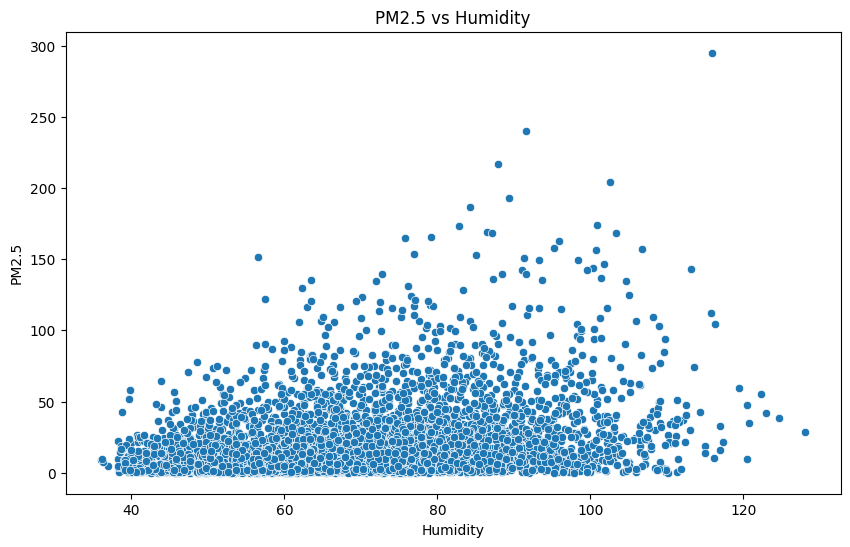

In [24]:
# Heatmap of PM2.5 vs. Humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Humidity', y='PM2.5', data=df)
plt.title('PM2.5 vs Humidity')
plt.show()

### Interpretation of PM2.5 vs Humidity:

1. **Relationship Between Humidity and PM2.5**:
   - There is no **clear correlation** between humidity and **PM2.5** levels.
   - **PM2.5** levels seem to slightly increase with higher humidity, but this trend is weak and non-linear.

2. **Main Ranges**:
   - Most **PM2.5** levels are below **50 µg/m³**, regardless of humidity.
   - Humidity is primarily concentrated between **40% and 100%**, with a few extreme values exceeding **120%**.

3. **Extreme Values**:
   - High **PM2.5** levels (>150 µg/m³) are observed across the entire range of humidity, though they are slightly more frequent at higher humidity levels.
   - These extreme levels are likely influenced by other factors, such as industrial proximity or local weather conditions.

While high humidity levels might contribute to elevated **PM2.5** levels, the relationship is neither strong nor consistent. This visualization suggests that other factors (e.g., industrial proximity or population density) play a more significant role in determining **PM2.5** levels.


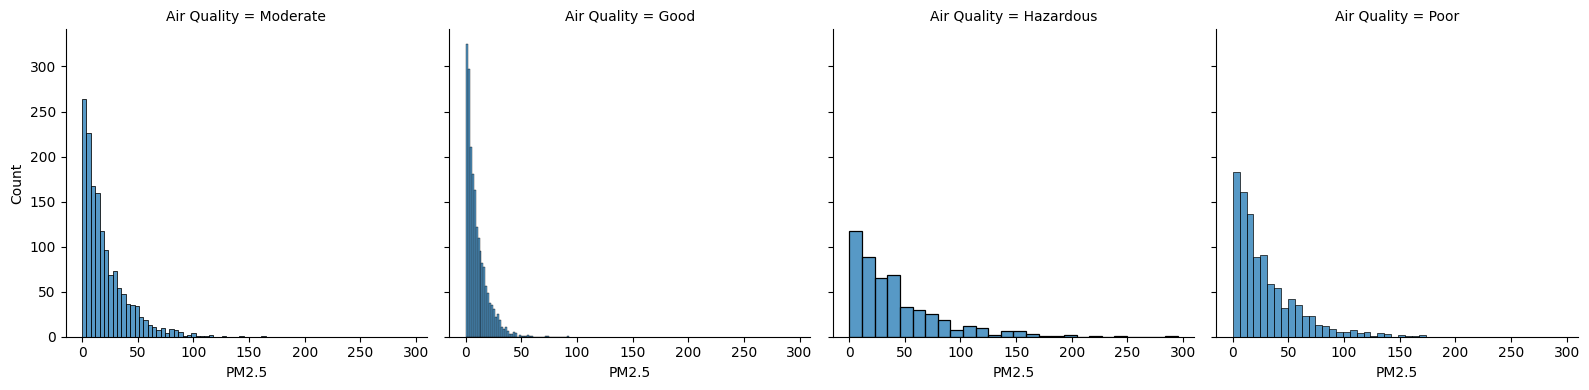

In [25]:
# Facet Grid for Pollutants by Air Quality
g = sns.FacetGrid(df, col='Air Quality', height=4, aspect=1)
g.map(sns.histplot, 'PM2.5')
plt.show()

### Interpretation of Air Quality:

1. **Air Quality = Good**:
   - The distribution of **PM2.5** levels is concentrated at lower values, primarily below **20 µg/m³**.
   - Extreme values are rare, with very few cases exceeding **50 µg/m³**.

2. **Air Quality = Moderate**:
   - The distribution is wider than the "Good" category, with most values between **10 and 50 µg/m³**.
   - A few outliers reach **100 µg/m³**, but these are infrequent.

3. **Air Quality = Poor**:
   - A noticeable increase in **PM2.5** levels is observed, with most values between **30 and 70 µg/m³**.
   - The distribution also shows a long tail, indicating extreme values that reach **150 µg/m³**.

4. **Air Quality = Hazardous**:
   - **PM2.5** levels are the highest in this category, with most values above **50 µg/m³**.
   - A significant proportion of data points exhibit extreme values (>150 µg/m³), reflecting severe pollution conditions.

### Overall Comparison:
- **PM2.5** levels increase significantly as air quality deteriorates.
- The "Poor" and "Hazardous" categories have broader distributions with higher average and extreme levels.

This visualization highlights a clear correlation between air quality and **PM2.5** levels. Regions classified as "Hazardous" require special attention to reduce fine particulate matter, as they exhibit critical concentrations that could significantly impact public health.


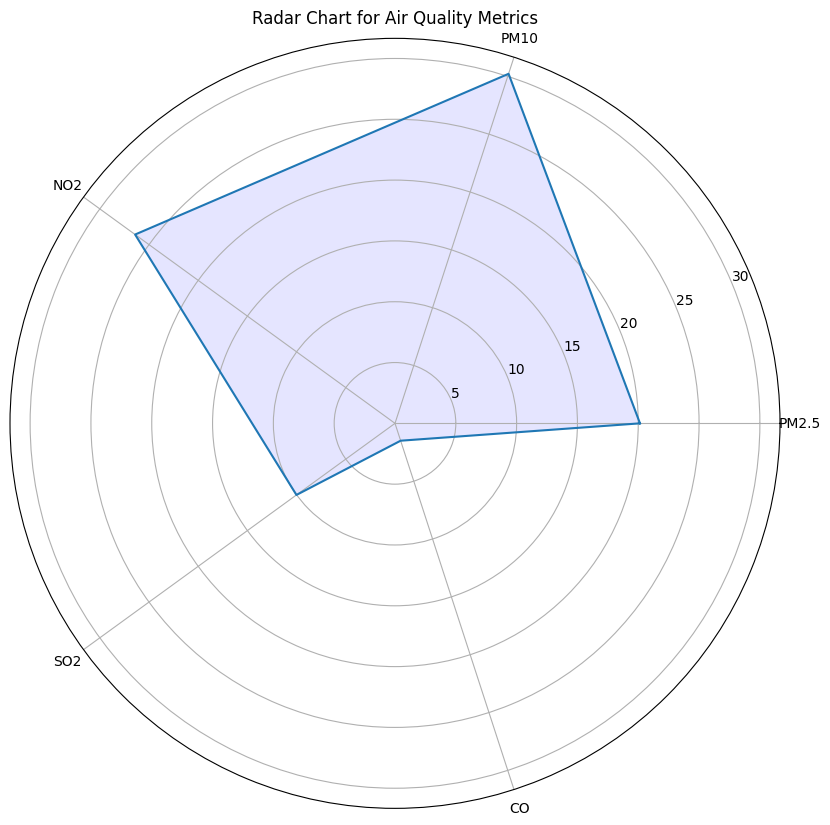

In [26]:
# Radar Chart (requires additional setup)
from math import pi
Categories = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']
values = [df[col].mean() for col in Categories]
N = len(Categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
values += values[:1]
angles += angles[:1]
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], Categories)
ax.plot(angles, values)
ax.fill(angles, values, 'b', alpha=0.1)
plt.title('Radar Chart for Air Quality Metrics')
plt.show()

### Interpretation of Radar Chart for Air Quality Metrics:

1. **Category Analysis**:
   - Average pollutant levels are represented on the radar chart.
   - **PM10** and **PM2.5** have the highest average values, highlighting their dominant role in air pollution.
   - Gases like **NO2**, **SO2**, and **CO** show significantly lower average levels, though they also contribute to air quality degradation.

2. **Radar Shape**:
   - The asymmetrical shape of the radar highlights the predominance of fine (**PM2.5**) and coarse (**PM10**) particulate matter compared to gases.
   - **SO2** and **CO** exhibit the lowest average levels, potentially reflecting successful control or limitations of these pollutants in certain regions.

3. **General Interpretation**:
   - This visualization emphasizes that particulate matter is the primary contributor to air pollution.
   - Although the gases (**NO2**, **SO2**, **CO**) are less dominant, they remain concerning and warrant attention, particularly in areas where their levels are elevated.

The radar chart confirms that **PM2.5** and **PM10** are the key metrics to target for improving air quality. While gases (NO2, SO2, CO) are less prominent, they play an essential role and should not be overlooked, especially in regions with higher concentrations. This chart provides a clear overview of pollutant reduction priorities.


# ***Data Preprocessing***

# ***Encoding label***
**Uses a `LabelEncoder` to convert the categorical values in the **'Air Quality'** column of the DataFrame `df` into numerical values for easier processing in machine learning or analysis.**

In [8]:
le=LabelEncoder()
df['Air Quality']=le.fit_transform(df['Air Quality'])
print(le.classes_)

['Good' 'Hazardous' 'Moderate' 'Poor']


In [9]:
print("Class mapping:")
for idx, label in enumerate(le.classes_):
    print(f"{idx}: {label}")


Class mapping:
0: Good
1: Hazardous
2: Moderate
3: Poor


# ***Data Preparation:***
**Splits the DataFrame `df` into two parts: `x`, which contains all columns except **'Air Quality'** (the features), and `y`, which contains only the **'Air Quality'** column (the target variable).**

In [10]:
x=df.drop(columns='Air Quality')
y=df['Air Quality']

# ***Train-Test Split:***
Splits the dataset into training and testing sets, with 80% of the data allocated for training (X_train, y_train) and 20% for testing (X_test, y_test), ensuring reproducibility with a random_state of 42.

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# ***Hyperparameter Tuning with Optuna***

Uses **Optuna** to optimize hyperparameters and select the best model among five classification algorithms: **Logistic Regression**, **KNN**, **SVC**, **Random Forest**, and **Gradient Boosting**.

1. **Objective**: Maximize the average accuracy (`accuracy`) through cross-validation.  
2. **`objective` Function**: Defines the hyperparameters to test for each model.  
3. **Optuna `study`**: Runs 20 trials to find the best combination of model and hyperparameters.  
4. **Result**: Displays the optimal model and hyperparameters (`study.best_params`).  

In [12]:
# Hyperparameter Tuning Function with Optuna
def objective(trial):
    model_name = trial.suggest_categorical('model', ['Logistic Regression', 'K-Nearest Neighbors', 'SVC', 'Random Forest', 'Gradient Boosting'])
    
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 0.01, 10.0)
        model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    elif model_name == 'K-Nearest Neighbors':
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model_name == 'SVC':
        C = trial.suggest_float('C', 0.01, 10.0)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        model = SVC(C=C, kernel=kernel, probability=True, random_state=42)
    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'Gradient Boosting':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

In [14]:
# Optuna to Find the Best Model
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-01-03 16:37:23,118] A new study created in memory with name: no-name-3b91d950-c212-4f33-bcb2-540ed5e72aee
[I 2025-01-03 16:37:23,255] Trial 0 finished with value: 0.7774979726940731 and parameters: {'model': 'K-Nearest Neighbors', 'n_neighbors': 10}. Best is trial 0 with value: 0.7774979726940731.
[I 2025-01-03 16:37:23,390] Trial 1 finished with value: 0.7704962222564636 and parameters: {'model': 'K-Nearest Neighbors', 'n_neighbors': 12}. Best is trial 0 with value: 0.7774979726940731.
[I 2025-01-03 16:37:26,138] Trial 2 finished with value: 0.746501467945697 and parameters: {'model': 'SVC', 'C': 0.8861031230043335, 'kernel': 'poly'}. Best is trial 0 with value: 0.7774979726940731.
[I 2025-01-03 16:37:29,490] Trial 3 finished with value: 0.9535014938142332 and parameters: {'model': 'Random Forest', 'n_estimators': 199, 'max_depth': 28}. Best is trial 3 with value: 0.9535014938142332.
[I 2025-01-03 16:37:30,915] Trial 4 finished with value: 0.9542524311737605 and parameters: {'

In [15]:
# Optuna Results
print(f"Best model parameters: {study.best_params}")
best_params = study.best_params

Best model parameters: {'model': 'Random Forest', 'n_estimators': 140, 'max_depth': 15}


# **Model Training and Evaluation**

This script trains and evaluates the selected model using the best hyperparameters and tracks the process with **MLflow**.

### **Key Features**:
1. **MLflow Integration**:  
   - Automatic logging of parameters, metrics, and artifacts with `mlflow.sklearn.autolog`.

2. **Model Training**:  
   - Trains the final model using the hyperparameters (`best_params`) on the training dataset.

3. **Performance Metrics**:  
   - Calculates metrics such as accuracy, F1-score, precision, recall, and log loss for both training and testing datasets.  
   - Generates classification reports for detailed insights by class.

4. **Visualizations**:  
   - Plots and logs ROC curves for both training and testing datasets.  
   - Creates and logs a confusion matrix as an artifact.

5. **Results Logging**:  
   - All metrics, ROC curves, and the confusion matrix are stored and visualized in MLflow for easy tracking.

It simplifies model evaluation while ensuring a comprehensive and automated performance analysis.


In [16]:
# Activate MLflow autologging
mlflow.sklearn.autolog(log_datasets=False)

Training Metrics by Class:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1591
     Class 1       1.00      0.98      0.99       389
     Class 2       0.99      1.00      1.00      1206
     Class 3       0.99      0.99      0.99       814

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000

Testing Metrics by Class:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       409
     Class 1       0.91      0.86      0.89       111
     Class 2       0.97      0.97      0.97       294
     Class 3       0.87      0.90      0.88       186

    accuracy                           0.96      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.96      0.96      0.96      1000



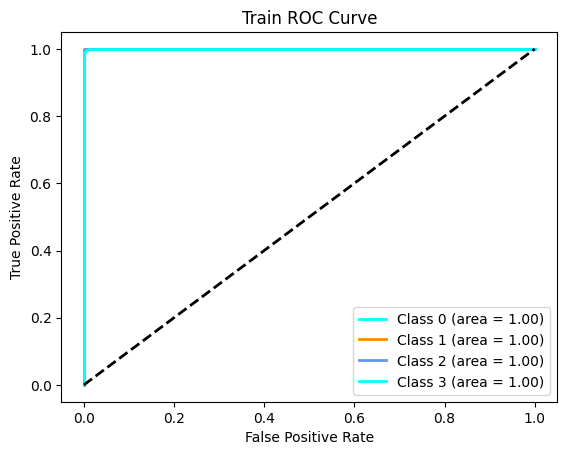

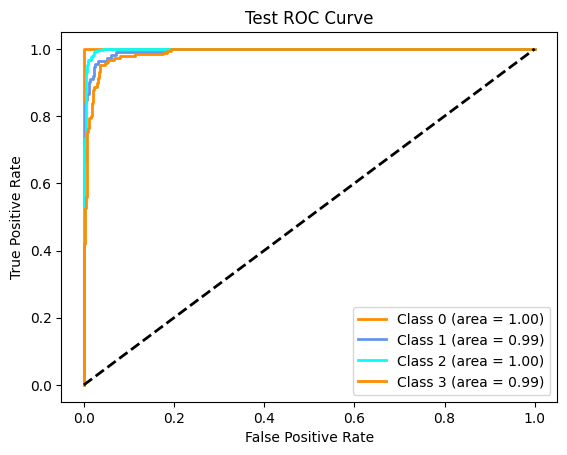

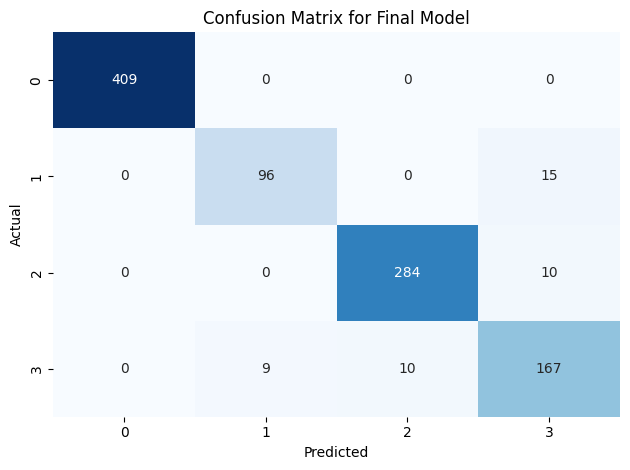

2025/01/03 16:38:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run jovial_salt_0my2y7qx at: https://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/63d64c73-ea7e-48d8-a711-44ad3926844b/resourceGroups/air-quality-project/providers/Microsoft.MachineLearningServices/workspaces/airqualityml/#/experiments/56fbfc85-1b39-4bf7-99cd-036cfd5c581f/runs/c70753ab-8ee0-4bb9-8879-1ac0de756be3.
2025/01/03 16:38:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/63d64c73-ea7e-48d8-a711-44ad3926844b/resourceGroups/air-quality-project/providers/Microsoft.MachineLearningServices/workspaces/airqualityml/#/experiments/56fbfc85-1b39-4bf7-99cd-036cfd5c581f.


In [17]:
# Train and Evaluate the Final Model
with mlflow.start_run():
    if best_params['model'] == 'Logistic Regression':
        final_model = LogisticRegression(C=best_params['C'], max_iter=1000, random_state=42)
    elif best_params['model'] == 'K-Nearest Neighbors':
        final_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    elif best_params['model'] == 'SVC':
        final_model = SVC(C=best_params['C'], kernel=best_params['kernel'], probability=True, random_state=42)
    elif best_params['model'] == 'Random Forest':
        final_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
    elif best_params['model'] == 'Gradient Boosting':
        final_model = GradientBoostingClassifier(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], random_state=42)

    # Training the model
    final_model.fit(X_train, y_train)

    # Predictions
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)

    # Metrics for train
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1_score = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_log_loss = log_loss(y_train, final_model.predict_proba(X_train))

    # Metrics for test
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_log_loss = log_loss(y_test, final_model.predict_proba(X_test))

    # Classification report for train and test (by class)
    train_class_report = classification_report(y_train, y_train_pred, target_names=[f"Class {c}" for c in np.unique(y_train)])
    test_class_report = classification_report(y_test, y_test_pred, target_names=[f"Class {c}" for c in np.unique(y_test)])

    # Print classification reports
    print("Training Metrics by Class:")
    print(train_class_report)

    print("Testing Metrics by Class:")
    print(test_class_report)

    # Log train metrics to MLflow
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_f1_score", train_f1_score)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_log_loss", train_log_loss)

    # Log test metrics to MLflow
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1_score", test_f1_score)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_log_loss", test_log_loss)

    # Define n_classes
    n_classes = len(np.unique(y_train))

    # Binarize labels
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

    # Calculate predicted probabilities
    y_train_proba = final_model.predict_proba(X_train)
    y_test_proba = final_model.predict_proba(X_test)

    # Plot ROC Curve for train
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Train ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_train.png")
    mlflow.log_artifact("roc_curve_train.png")
    plt.show()

    # Plot ROC Curve for test
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_test.png")
    mlflow.log_artifact("roc_curve_test.png")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Final Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("confusion_matrix_test.png")
    mlflow.log_artifact("confusion_matrix_test.png")
    plt.show()


The results demonstrate that the **Random Forest model** achieves high accuracy (**96%**) in predicting air quality categories. Here's a breakdown:

1. **Performance Metrics**:
   - **Precision, recall, and F1-scores** are high across all classes, particularly for class `0` (perfect scores).
   - Class `3` has slightly lower precision and recall but still performs well.

2. **Confusion Matrix Insights**:
   - Most predictions align with actual labels.
   - Minimal misclassifications occur in classes `1`, `2`, and `3`, indicating strong model reliability.

3. **Best Model Configuration**:
   - **Random Forest** with best parameters  was selected after optimization trials.

The model is robust and suitable for predicting air quality, with only minor room for improvement in the lower-performing classes.

# ***Save Final Model : ***
This code saves a trained model in MLflow format if the specified directory does not already exist or is empty. It then registers the model in the model registry with a formatted name, description, and version.

In [18]:
# Path to a directory (not just a file)
mlflow_model_dir = "outputs/mlflow_model"

# Check if the directory already exists and is not empty
if os.path.exists(mlflow_model_dir) and any(os.scandir(mlflow_model_dir)):
    print(f"The directory '{mlflow_model_dir}' already exists and is not empty.")
else:
    # Save the final model in MLflow format
    mlflow.sklearn.save_model(
        sk_model=final_model,  
        path=mlflow_model_dir  
    )
    # Confirmation message that the model has been saved
    print(f"Model saved in '{mlflow_model_dir}'.")


The directory 'outputs/mlflow_model' already exists and is not empty.


In [19]:
# Prepare the model name by formatting it
model_name = best_params['model'].replace(" ", "_").replace("-", "_").lower()

# Define a registered model object
registered_model = Model(
    name=model_name,         
    path=mlflow_model_dir,   
    description="Best Optuna model (MLflow format)", 
    type="mlflow_model"     
)

# Register or update the model in the model registry
registered_model = ml_client.models.create_or_update(registered_model)

# Print confirmation with model name and version
print(f"Model registered with name={registered_model.name}, version={registered_model.version}")


Model registered with name=random_forest, version=3


# ***Generate and deploy an endpoint: ***
This code creates and deploys an online endpoint in Azure Machine Learning for air quality prediction. It initializes the endpoint, defines the deployment configuration with a scoring script (`score.py`), deploys a trained model, logs metrics and predictions, and tests the endpoint by sending sample data via a POST request to retrieve predictions.

### Generate the endpoint name:

In [25]:
# Generate a unique endpoint name to avoid collisions
random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4)) 
endpoint_name = f"air-quality-endpoint-{random_suffix}"  
print("Endpoint name:", endpoint_name)  

Endpoint name: air-quality-endpoint-qdyh


### Create Endpoint : 

In [26]:
# Création de l’endpoint (auth_mode="key" ou "aml_token")
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    auth_mode="key"
)
endpoint_result = ml_client.begin_create_or_update(endpoint).result()
print(f"Endpoint '{endpoint_result.name}' created or updated.")


Endpoint 'air-quality-endpoint-qdyh' created or updated.


### Create score.py : 
This `score.py` script is designed to deploy a machine learning model as an endpoint on Azure. During initialization, it loads the model stored in the directory specified by the `AZUREML_MODEL_DIR` environment variable. It sets up a logging system using Azure Application Insights to track logs and metrics. The `run` function serves as the entry point for incoming requests, accepting data in JSON format. It validates and parses the input data before making predictions with the loaded model. Prediction time and total processing time are measured and recorded in both MLflow and Application Insights for performance monitoring. The prediction results are mapped to readable labels and returned as JSON. In case of errors, the script handles exceptions and returns appropriate error messages. This integration allows for effective monitoring, tracing, and management of requests and endpoint performance on Azure. Finally, the script ensures that all necessary dependencies are loaded and properly configured for smooth operation on the Azure platform.


In [49]:
script_content = '''
import logging
import time
import json
import numpy as np
import joblib
import os
from opencensus.ext.azure.log_exporter import AzureLogHandler
from opencensus.trace import tracer as tracer_module
from opencensus.trace.samplers import ProbabilitySampler
import mlflow

# Configure the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Add Azure Application Insights handler if the connection string is available
app_insights_connection_string = os.getenv("APPINSIGHTS_CONNECTION_STRING", "")
if app_insights_connection_string:
    azure_handler = AzureLogHandler(connection_string=app_insights_connection_string)
    logger.addHandler(azure_handler)
    logger.info("Application Insights handler added successfully.")
else:
    logger.warning("No Application Insights Connection String found.")

# Configure the tracer with a probability sampler (100% sampling rate)
tracer = tracer_module.Tracer(sampler=ProbabilitySampler(1.0))

# Mapping of class indices to their respective labels
CLASS_MAPPING = {
    0: "Good",
    1: "Hazardous",
    2: "Moderate",
    3: "Poor"
}

# Global variable to hold the loaded model
model = None

def init():
    """
    Initializes the model by loading it from the specified directory.
    This function should be called once when the application starts.
    """
    global model
    try:
        # Retrieve the model directory from environment variables
        model_root = os.getenv("AZUREML_MODEL_DIR")
        if not model_root:
            raise EnvironmentError("AZUREML_MODEL_DIR environment variable is not set.")
        
        # Construct the full path to the model file
        model_path = os.path.join(model_root, "mlflow_model", "model.pkl")
        
        # Load the model using joblib
        model = joblib.load(model_path)
        logger.info(f"Model loaded successfully from {model_path}.")
    except Exception as e:
        logger.error(f"Failed to load the model: {e}")
        raise

def run(data: str) -> dict:
    """
    Processes input data to make predictions using the loaded model.

    Parameters:
        data (str): JSON-formatted string containing the input data.

    Returns:
        dict: A dictionary with prediction results or an error message.
    """
    with tracer.span(name="PredictionRequest"):
        start_time = time.time()
        try:
            # Parse the input JSON data
            input_json = json.loads(data)
            logger.info(f"Received input data: {input_json}")

            # Extract the features matrix from the input data
            features = input_json.get("data")
            if features is None:
                raise KeyError("Missing 'data' field in input JSON.")

            # Validate the format of the input features
            if not isinstance(features, list) or not all(isinstance(row, list) and len(row) == 9 for row in features):
                raise ValueError("Invalid input format. Expecting a list of lists with 9 features each.")
        except json.JSONDecodeError as e:
            logger.error(f"JSON decoding error: {e}")
            return {"error": "Invalid JSON format."}
        except (KeyError, ValueError) as e:
            logger.error(f"Input validation error: {e}")
            return {"error": str(e)}
        except Exception as e:
            logger.error(f"Unexpected error during input parsing: {e}")
            return {"error": "An unexpected error occurred while parsing input data."}

        try:
            # Record the time before making predictions
            prediction_start_time = time.time()

            # Make predictions using the loaded model
            predictions = model.predict(features)
            prediction_duration = time.time() - prediction_start_time

            # Calculate the total latency of the request
            total_latency = time.time() - start_time

            # Process all predictions
            formatted_predictions = []
            for pred in predictions:
                class_index = int(pred)
                class_label = CLASS_MAPPING.get(class_index, "Unknown")
                formatted_predictions.append(
                    f"prediction : class_index : {class_index}, class_label : \"{class_label}\", latency_seconds : {round(prediction_duration / len(predictions), 6)}"
                )

            # Log prediction details
            logger.info(
                f"Predictions made: {formatted_predictions}, "
                f"prediction_time={prediction_duration:.4f}s, total_latency={total_latency:.4f}s"
            )

            # Log metrics to MLflow
            mlflow.log_metric("prediction_latency", prediction_duration)
            mlflow.log_metric("total_latency", total_latency)
            mlflow.log_metric("input_data_size", len(features))

            # Log custom dimensions to Azure Application Insights
            logger.info({
                "custom_dimensions": {
                    "prediction_latency": prediction_duration,
                    "total_latency": total_latency,
                    "input_data_size": len(features),
                }
            })

            # Construct a structured response
            response = {
                "predictions": formatted_predictions,
                "total_latency_seconds": round(total_latency, 6)
            }
            return response
        except Exception as e:
            logger.error(f"Error during prediction: {e}")
            return {"error": "An error occurred during prediction."}
'''

# Writing to a score.py file
with open("score.py", "w") as script_file:
    script_file.write(script_content)

print("The score.py script was created successfully.")


The score.py script was created successfully.


### Create the "blue" deployment : 

In [27]:
# Create a CodeConfiguration object specifying the location of "score.py"
code_configuration = CodeConfiguration(
    code=".",                  # Directory containing "score.py"
    scoring_script="score.py"  # Name of the scoring script
)

# Define the deployment configuration
deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,      
    model=registered_model,             
    environment="custom-mlflow-env:1", 
    code_configuration=code_configuration,  
    instance_type="Standard_F2s_v2",    
    instance_count=1                    
)

# Create or update the deployment and wait for the operation to complete
deployment_result = ml_client.begin_create_or_update(deployment).result()

# Print a confirmation message with the deployment name
print(f"Deployment '{deployment_result.name}' has been created or updated successfully.")


Check: endpoint air-quality-endpoint-qdyh exists
Uploading edwin.savory (69.23 MBs): 100%|██████████| 69231958/69231958 [00:00<00:00, 99201813.62it/s] 




..........................................................................Deployment 'blue' has been created or updated successfully.


In [28]:
logs = ml_client.online_deployments.get_logs(
    name="blue",
    endpoint_name=endpoint_name,
    lines=200  
)

print(logs)


Instance status:
SystemSetup: Succeeded
UserContainerImagePull: Succeeded
ModelDownload: Succeeded
UserContainerStart: Succeeded

Container events:
Kind: Pod, Name: Pulling, Type: Normal, Time: 2025-01-03T16:50:59.326986Z, Message: Start pulling container image
Kind: Pod, Name: Downloading, Type: Normal, Time: 2025-01-03T16:50:59.795398Z, Message: Start downloading models
Kind: Pod, Name: Pulled, Type: Normal, Time: 2025-01-03T16:52:51.229471Z, Message: Container image is pulled successfully
Kind: Pod, Name: Downloaded, Type: Normal, Time: 2025-01-03T16:52:51.229471Z, Message: Models are downloaded successfully
Kind: Pod, Name: Created, Type: Normal, Time: 2025-01-03T16:52:51.314738Z, Message: Created container inference-server
Kind: Pod, Name: Started, Type: Normal, Time: 2025-01-03T16:52:51.414118Z, Message: Started container inference-server
Kind: Pod, Name: ContainerReady, Type: Normal, Time: 2025-01-03T16:53:04.812948322Z, Message: Container is ready

Container logs:
google-auth @

### Traffic Update : 

In [29]:
# Router 100% du trafic vers le déploiement "blue"
endpoint.traffic = {"blue": 100}
endpoint_updated = ml_client.begin_create_or_update(endpoint).result()
print(f"Traffic updated: {endpoint_updated.traffic}")


Traffic updated: {'blue': 100}


### Test the endpoint : 

In [47]:
# Define the endpoint information and the API key
endpoint_url = "https://air-quality-endpoint-qdyh.westeurope.inference.ml.azure.com/score"
api_key = "bfaeMyg0ySrKDFIZzEtx0pCKbp6pNY20"

# Test data
test_data = {
    "data": [
        [25.0, 65.0, 12.0, 30.0, 10.0, 2.0, 1.0, 5.0, 2000],
        [18.0, 70.0, 15.0, 40.0, 12.0, 1.0, 0.5, 3.0, 1500]
    ]
}

# HTTP headers
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Send the POST request
response = requests.post(endpoint_url, headers=headers, data=json.dumps(test_data))

# Display the results
print("Status Code:", response.status_code)
print("Response Body:", response.json())


Status Code: 200
Response Body: {'predictions': ['prediction : class_index : 2, class_label : "Moderate", latency_seconds : 0.004071', 'prediction : class_index : 2, class_label : "Moderate", latency_seconds : 0.004071'], 'total_latency_seconds': 0.008341}


# ***Streamlit Interface :***

## Streamlit app.py : 

In [55]:
script_content = '''
import streamlit as st
import requests
import json

# Application Configuration
st.title("Air Quality Prediction Interface")
st.write("Enter the necessary data to predict air quality using the deployed model.")

# Define the endpoint URL and API key
ENDPOINT_URL = "https://air-quality-endpoint-mrw2.westeurope.inference.ml.azure.com/score"
API_KEY = "DcYh1EXGaVYZS1FNytWdrfYncEl4oMgo"

if not API_KEY:
    st.error("API key is missing. Please define it in the script.")
    st.stop()

# User Inputs
st.header("User Inputs")

temperature = st.number_input(
    "Temperature (°C)", min_value=-30.0, max_value=50.0, step=0.1, format="%.1f"
)
humidity = st.number_input(
    "Humidity (%)", min_value=0.0, max_value=100.0, step=0.1, format="%.1f"
)
pm25 = st.number_input(
    "PM2.5 Concentration (µg/m³)", min_value=0.0, step=0.1, format="%.1f"
)
pm10 = st.number_input(
    "PM10 Concentration (µg/m³)", min_value=0.0, step=0.1, format="%.1f"
)
no2 = st.number_input(
    "NO₂ Concentration (ppb)", min_value=0.0, step=0.1, format="%.1f"
)
so2 = st.number_input(
    "SO₂ Concentration (ppb)", min_value=0.0, step=0.1, format="%.1f"
)
co = st.number_input(
    "CO Concentration (ppm)", min_value=0.0, step=0.01, format="%.2f"
)
proximity = st.number_input(
    "Proximity to Industrial Areas (km)", min_value=0.0, step=0.1, format="%.1f"
)
density = st.number_input(
    "Population Density (people/km²)", min_value=0, step=1
)

# Function to prepare input data for the API
def prepare_input_data(*args):
    """Prepare the input data in the required format for the API."""
    return {"data": [list(args)]}

# Function to send a POST request to the API
def get_air_quality_prediction(input_data, endpoint, api_key):
    """
    Send a POST request to the air quality prediction API.

    Parameters:
        input_data (dict): The data to send in the request.
        endpoint (str): The API endpoint URL.
        api_key (str): The API authentication key.

    Returns:
        dict: The JSON response from the API if successful.
        None: If the request fails.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    try:
        response = requests.post(endpoint, headers=headers, data=json.dumps(input_data))
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
        return response.json()
    except requests.exceptions.HTTPError as http_err:
        st.error(f"HTTP error occurred: {http_err} - {response.text}")
    except requests.exceptions.RequestException as req_err:
        st.error(f"Request error occurred: {req_err}")
    except Exception as e:
        st.error(f"An unexpected error occurred: {e}")
    return None

# Button to send the request
if st.button("Predict"):
    # Prepare the input data for the API
    input_data = prepare_input_data(
        temperature, humidity, pm25, pm10, no2, so2, co, proximity, density
    )

    # Get the prediction from the API
    prediction_response = get_air_quality_prediction(input_data, ENDPOINT_URL, API_KEY)

    # Display the prediction result
    if prediction_response:
        # Extract predictions from the response
        predictions = prediction_response.get("predictions", [])
        
        if predictions:
            # Parse and display each prediction without a prefix
            st.success("Air Quality Predictions:")
            for pred in predictions:
                st.write(pred)  # Directly display the string
        else:
            st.error("No predictions found in the API response.")
    else:
        st.error("Failed to get a response from the API.")
'''

# Writing to a app.py file
with open("app.py", "w") as script_file:
    script_file.write(script_content)

print("The app.py script was created successfully.")


The app.py script was created successfully.


### Run the app.py

```
streamlit run app.py -- --endpoint "YOUR_REST_endpoint" --api_key "YOUR_API_KEY"
```

## How to Launch:

### Step 1: Download and Install Ngrok
1. Open your compute instance terminal.
2. Download **ngrok** using the following command:
   ```bash
   wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-stable-linux-amd64.zip
   ```
3. Unzip the downloaded file:
   ```bash
   unzip ngrok-stable-linux-amd64.zip
   ```
4. Move the ngrok binary to a global directory for easy access:
   ```bash
   sudo mv ngrok /usr/local/bin
   ```

5. Verify the installation:
   ```bash
   ngrok version
   ```

---

### Step 2: Configure Ngrok
1. Log in to your [Ngrok account](https://dashboard.ngrok.com/) and copy your **authentication token**.
2. Add your **Ngrok authentication token** in the terminal:
   ```bash
   ngrok config add-authtoken <YOUR_AUTH_TOKEN>
   ```
3. Confirm the token has been added successfully:
   ```bash
   cat ~/.config/ngrok/ngrok.yml
   ```

---

### Step 3: Launch the Application
1. Navigate to the directory where your Streamlit app (`app.py`) is located:
   ```bash
   cd /path/to/your/app
   ```
2. Run your Streamlit app:
   ```bash
   streamlit run app.py
   ```

---

### Step 4: Expose the Application to the Internet
1. Open a **new terminal** and ensure you’re in the same compute instance.
2. Use Ngrok to expose the Streamlit app:
   ```bash
   ngrok http 8501
   ```
   (Replace `8501` with the port used by your Streamlit app if different.)

3. Ngrok will display a public URL in the terminal, such as:
   ```
   https://<generated_subdomain>.ngrok.io
   ```

---

### Step 5: Access the Application
1. Copy the public URL displayed by Ngrok.
2. Open your browser and paste the URL to access your live Streamlit application.

---

### Troubleshooting Tips:
- If you encounter a "Command not found" error for `unzip`, install it with:
  ```bash
  sudo apt-get update
  sudo apt-get install unzip
  ```
- If the Ngrok public URL doesn’t work, verify that the port (e.g., 8501) matches the port your Streamlit app is running on.
- Ensure your firewall rules allow external traffic to the required ports.



# ***Application Insights : ***
This code updates an existing online deployment in Azure Machine Learning by enabling Application Insights for monitoring and then updating the deployment's scoring script (score.py) with a new configuration. Additionally, it configures logging to send test logs to Application Insights using a provided connection string.

## Enable the Insights app :

In [56]:
# Load the existing deployment
deployment_name = "blue"  # Name of the deployment
endpoint_name = endpoint_name  # Name of the endpoint

# Retrieve the deployment details
deployment = ml_client.online_deployments.get(endpoint_name=endpoint_name, name=deployment_name)

# Enable Application Insights
deployment.app_insights_enabled = True

# Update the deployment
updated_deployment = ml_client.online_deployments.begin_create_or_update(deployment).result()

# Print confirmation message
print(f"App Insights enabled for deployment {deployment_name}.")

Check: endpoint air-quality-endpoint-eysp exists


...........................................App Insights enabled for deployment blue.


### Update the score.py for the endpoint :

In [45]:
# Existing deployment and endpoint names
deployment_name = "blue"  # Name of the deployment
endpoint_name = endpoint_name  # Replace with your endpoint name

# Configuration for the new score.py
new_code_config = CodeConfiguration(
    code=".",  # Folder containing the score.py file
    scoring_script="score.py"  # Name of the score.py file
)

# Load the existing deployment
deployment = ml_client.online_deployments.get(endpoint_name=endpoint_name, name=deployment_name)

# Update only the code configuration
deployment.code_configuration = new_code_config

# Update the deployment
updated_deployment = ml_client.online_deployments.begin_create_or_update(deployment).result()

# Print confirmation message
print(f"The score.py file has been updated for deployment {deployment_name}.")


Check: endpoint air-quality-endpoint-qdyh exists
Uploading edwin.savory (69.23 MBs): 100%|██████████| 69232511/69232511 [00:01<00:00, 65245922.51it/s] 




..........................................The score.py file has been updated for deployment blue.


## Test the insights log application :

In [64]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = AzureLogHandler(connection_string="InstrumentationKey=806d17a6-17a4-4843-8c81-0d3f4fcfce7a;IngestionEndpoint=https://westeurope-5.in.applicationinsights.azure.com/")
logger.addHandler(handler)

logger.info("Test log to Application Insights")


# ***Convert Jupyter notebook to python script : ***

Now that we have explored, analyzed, and trained our data, we can convert our notebook into a Python script to begin creating our data pipeline.

In [69]:
!jupyter nbconvert --to script data_exploration_and_training.ipynb \
    --output-dir=./src


[NbConvertApp] Making directory ./src
[NbConvertApp] Converting notebook data_exploration_and_training.ipynb to script
[NbConvertApp] Writing 40797 bytes to src/data_exploration_and_training.py
